<a href="https://colab.research.google.com/github/rjain125/Week-3---Credit-Card-Fraud-Detection/blob/master/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#importing dependencies

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Using kaggle api

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [4]:
#importing data from kaggle

!kaggle competitions download -c ieee-fraud-detection -p /content/drive/My\ Drive/kaggle/fraud_detection

train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import os
os.chdir('/content/drive/My Drive/kaggle/fraud_detection')

In [0]:
!mkdir train  
!mkdir test  
!unzip -q train_transaction.csv.zip -d train/ 
!unzip -q train_identity.csv.zip -d train/  

!unzip -q test_transaction.csv.zip -d test/  
!unzip -q test_identity.csv.zip -d test/  
!unzip sample_submission.csv.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [4]:
os.chdir('/content/drive/My Drive/kaggle/fraud_detection/test')  

df_test_transaction = pd.read_csv('test_transaction.csv')
df_test_identity = pd.read_csv('test_identity.csv')


os.chdir('/content/drive/My Drive/kaggle/fraud_detection/train')  

df_train_transaction = pd.read_csv('train_transaction.csv')

df_train_identity = pd.read_csv('train_identity.csv')


df_test_transaction.head()



,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_test_identity.head()


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [19]:
df_train_transaction.head()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df_train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [0]:
#Function to reduce the dataframe size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
%%time
df_train_identity = reduce_mem_usage(df_train_identity)
df_test_identity = reduce_mem_usage(df_test_identity)
df_train_transaction = reduce_mem_usage(df_train_transaction)
df_test_transaction = reduce_mem_usage(df_test_transaction)

Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
CPU times: user 2min 35s, sys: 3.62 s, total: 2min 39s
Wall time: 2min 39s


In [7]:
#merging csv files
%%time
df_train = pd.merge(df_train_transaction, df_train_identity, on='TransactionID', how='left')
df_test = pd.merge(df_test_transaction, df_test_identity, on='TransactionID', how='left')

CPU times: user 5.6 s, sys: 345 ms, total: 5.95 s
Wall time: 5.96 s


In [0]:
#deleting files to free up space
del df_train_identity, df_train_transaction, df_test_identity, df_test_transaction

In [9]:
values = df_train.notnull().sum().sort_values(ascending=False)
missing_per = ((values)/len(df_train)) * 100
pd.concat([values, missing_per], keys=['Values', 'Not Missing %'], axis=1)

,Values,Not Missing %
TransactionID,590540,100.000000
C9,590540,100.000000
C1,590540,100.000000
C2,590540,100.000000
C3,590540,100.000000
C4,590540,100.000000
C5,590540,100.000000
C6,590540,100.000000
card1,590540,100.000000
C8,590540,100.000000


In [0]:
def delete_missing_data(data):
    null_cols = [col for col in data.columns if data[col].isnull().sum()/data.shape[0]>0.9]
    return null_cols

In [11]:
duplicate = df_train.duplicated()
sum(duplicate)
repeated_values = [col for col in df_train.columns if df_train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
repeated_values

['isFraud',
 'dist2',
 'C3',
 'D7',
 'V98',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V129',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V281',
 'V284',
 'V286',
 'V290',
 'V293',
 'V295',
 'V296',
 'V297',
 'V298',
 'V299',
 'V300',
 'V301',
 'V305',
 'V309',
 'V311',
 'V316',
 'V318',
 'V319',
 'V320',
 'V321',
 'id_07',
 'id_08',
 'id_18',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27']

In [0]:
def get_repeated_val(data):
    big_top_value_cols = [col for col in data.columns if data[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    return big_top_value_cols

In [0]:
def get_useless_columns(data, target):
    too_many_null = delete_missing_data(data)
    print("More than 90% null: " + str(len(too_many_null)))
    too_many_repeated = get_repeated_val(data)
    print("More than 90% repeated value: " + str(len(too_many_repeated)))
    cols_to_drop = list(set(too_many_null + too_many_repeated))
    cols_to_drop.remove(target)
    return cols_to_drop

In [14]:
cols_to_drop = get_useless_columns(df_train, 'isFraud')

More than 90% null: 12
More than 90% repeated value: 67


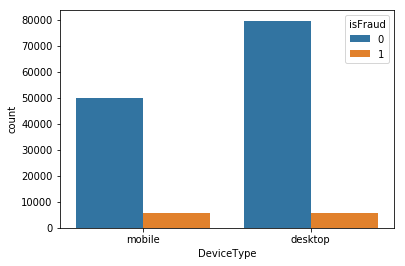

In [15]:
sns.countplot(df_train['DeviceType'], hue='isFraud', data=df_train)

In [16]:
#cards transaction
for i in range(1, 10):
    print(df_train['M' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

T      0.540886
NaN    0.459071
F      0.000042
Name: M1, dtype: float64


T      0.483402
NaN    0.459071
F      0.057527
Name: M2, dtype: float64


NaN    0.459071
T      0.426273
F      0.114656
Name: M3, dtype: float64


NaN    0.476588
M0     0.332585
M2     0.101373
M1     0.089454
Name: M4, dtype: float64


NaN    0.593494
F      0.224356
T      0.182150
Name: M5, dtype: float64


F      0.385843
T      0.327368
NaN    0.286788
Name: M6, dtype: float64


NaN    0.586353
F      0.357933
T      0.055713
Name: M7, dtype: float64


NaN    0.586331
F      0.262897
T      0.150772
Name: M8, dtype: float64


NaN    0.586331
T      0.348251
F      0.065418
Name: M9, dtype: float64




In [17]:
def adding_uid(data):
    data['uid1'] = data['card1'].astype(str)+'_'+data['card2'].astype(str)
    data['uid2'] = data['uid1'].astype(str)+'_'+data['card3'].astype(str)+'_'+data['card5'].astype(str)
    data['uid3'] = data['uid2'].astype(str)+'_'+data['addr1'].astype(str)+'_'+data['addr2'].astype(str)
    return data

df_train = adding_uid(df_train)
df_test = adding_uid(df_test)


i_cols = ['card1','card2','card3','card5','uid1','uid2','uid3']

for col in i_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([df_train[[col, 'TransactionAmt']], df_test[[col,'TransactionAmt']]])
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})

        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   

        df_train[new_col_name] = df_train[col].map(temp_df)
        df_test[new_col_name]  = df_test[col].map(temp_df)


df_train = df_train.replace(np.inf,999)
df_test = df_test.replace(np.inf,999)

df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,uid1,uid2,uid3,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid1_TransactionAmt_mean,uid1_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,uid3_TransactionAmt_mean,uid3_TransactionAmt_std
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13926_nan,13926_nan_150.0_142.0,13926_nan_150.0_142.0_315.0_87.0,316.5000,999.0000,NaN,NaN,147.625,255.25,185.250,999.000,258.0000,210.7500,258.0000,210.7500,193.0000,176.1250
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2755_404.0,2755_404.0_150.0_102.0,2755_404.0_150.0_102.0_325.0_87.0,213.0000,999.0000,227.125,999.000,147.625,255.25,212.750,999.000,213.6250,999.0000,213.6250,999.0000,240.0000,999.0000
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4663_490.0,4663_490.0_150.0_166.0,4663_490.0_150.0_166.0_330.0_87.0,104.8750,130.3750,136.125,228.625,147.625,255.25,98.750,141.125,104.8125,130.3750,104.8125,130.3750,65.6875,55.1875
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18132_567.0,18132_567.0_150.0_117.0,18132_567.0_150.0_117.0_476.0_87.0,120.9375,196.5000,133.625,226.750,147.625,255.25,124.375,191.875,120.9375,196.7500,120.9375,196.7500,113.0625,211.7500
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,4497_514.0,4497_514.0_150.0_102.0,4497_514.0_150.0_102.0_420.0_87.0,99.8125,69.8125,223.750,999.000,147.625,255.25,212.750,999.000,99.8125,69.8125,99.8125,69.8125,50.0000,NaN


In [0]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other',
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    df_train[c + '_bin'] = df_train[c].map(emails)
    df_test[c + '_bin'] = df_test[c].map(emails)
    
    df_train[c + '_suffix'] = df_train[c].map(lambda x: str(x).split('.')[-1])
    df_test[c + '_suffix'] = df_test[c].map(lambda x: str(x).split('.')[-1])
    
    df_train[c + '_suffix'] = df_train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    df_test[c + '_suffix'] = df_test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [0]:
p = 'P_emaildomain'
r = 'R_emaildomain'
unknown = 'unknown'

def setDomain(data):
    data[p] = data[p].fillna(unknown)
    data[r] = data[r].fillna(unknown)
    
    ## Where P domain matches R.
    ## putting 1 on the email_same col otherwise 0.
    data['email_same'] = np.where((data[p] == data[r]) & (data[p] != unknown), 1, 0)
    data[p+'_prefix'] = data[p].apply(lambda x: x.split('.')[0])
    data[r+'_prefix'] = data[r].apply(lambda x: x.split('.')[0])
    return data

df_train = setDomain(df_train)
df_test = setDomain(df_test)

In [0]:
#Transaction time
from datetime import datetime
from datetime import timedelta

START_DATE = datetime.strptime('2017-11-30', '%Y-%m-%d')

def setTime(df):
    df['TransactionDT'] = df['TransactionDT'].fillna(df['TransactionDT'].median())
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + timedelta(seconds = x)))
    df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    # Lets transform D8 and D9 column
    # As we almost sure it has connection with hours
    df['D9_not_na'] = np.where(df['D9'].isna(),0,1)
    df['D8_not_same_day'] = np.where(df['D8']>=1,1,0)
    df['D8_D9_decimal_dist'] = df['D8'].fillna(0)-df['D8'].fillna(0).astype(int)
    df['D8_D9_decimal_dist'] = ((df['D8_D9_decimal_dist']-df['D9'])**2)**0.5
    df['D8'] = df['D8'].fillna(-1).astype(int)

    return df

df_train = setTime(df_train)
df_test = setTime(df_test)






In [0]:
#Browser version

df_train["lastest_browser"] = np.zeros(df_train.shape[0])
df_test["lastest_browser"] = np.zeros(df_test.shape[0])

def setBrowser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'lastest_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'lastest_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'lastest_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'lastest_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'lastest_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'lastest_browser']=1
    return df

df_train=setBrowser(df_train)
df_test=setBrowser(df_test)


In [0]:
#device type

def setDevice(df):
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]

    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    return df
  
df_train = setDevice(df_train)
df_test = setDevice(df_test)


In [0]:
#

i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','device_name',
          'id_30','id_33',
          'uid1','uid2','uid3',
         ]

for col in i_cols:
    temp_df = pd.concat([df_train[[col]], df_test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    df_train[col+'_fq_enc'] = df_train[col].map(fq_encode)
    df_test[col+'_fq_enc']  = df_test[col].map(fq_encode)


for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([df_train[[col]], df_test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    df_train[col+'_total'] = df_train[col].map(fq_encode)
    df_test[col+'_total']  = df_test[col].map(fq_encode)

periods = ['DT_M','DT_W','DT_D']
i_cols = ['uid1']
for period in periods:
    for col in i_cols:
        new_column = col + '_' + period
        temp_df = pd.concat([df_train[[col,period]], df_test[[col,period]]])
        temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
        fq_encode = temp_df[new_column].value_counts().to_dict()
            
        df_train[new_column] = (df_train[col].astype(str) + '_' + df_train[period].astype(str)).map(fq_encode)
        df_test[new_column]  = (df_test[col].astype(str) + '_' + df_test[period].astype(str)).map(fq_encode)
        
        df_train[new_column] /= df_train[period+'_total']
        df_test[new_column]  /= df_test[period+'_total']

        

In [24]:
#data preparation for training


df_train = df_train.drop(cols_to_drop, axis=1)

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attr):
        self.attributes = attr
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attributes].values

from sklearn.preprocessing import LabelEncoder

class ModifiedLabelEncoder(LabelEncoder):
    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(y).reshape(-1, 1)
    def transform(self, y, *args, **kwargs):
        return super().transform(y).reshape(-1, 1)


noisy_cols = [
    'TransactionID','TransactionDT',                      
    'uid1','uid2','uid3',                                 
    'DT','DT_M','DT_W','DT_D',       
    'DT_hour','DT_day_week','DT_day',
    'DT_D_total','DT_W_total','DT_M_total',
    'id_30','id_31','id_33',
    'D1', 'D2', 'D9',
]

noisy_cat_cols = list(df_train[noisy_cols].select_dtypes(include=['object']).columns) 
noisy_num_cold = list(df_train[noisy_cols].select_dtypes(exclude=['object']).columns)

cat_attr = list(df_train.select_dtypes(include=['object']).columns)
num_attr = list(df_train.select_dtypes(exclude=['object']).columns)
num_attr.remove('isFraud')

for col in noisy_cat_cols:
    if col in cat_attr:
        print("Deleting " + col)
        cat_attr.remove(col)
for col in noisy_num_cold:
    if col in num_attr:
        print("Deleting " + col)
        num_attr.remove(col)

Deleting uid1
Deleting uid2
Deleting uid3
Deleting id_30
Deleting id_31
Deleting id_33
Deleting TransactionID
Deleting TransactionDT
Deleting DT
Deleting DT_M
Deleting DT_W
Deleting DT_D
Deleting DT_hour
Deleting DT_day_week
Deleting DT_day
Deleting DT_D_total
Deleting DT_W_total
Deleting DT_M_total
Deleting D1
Deleting D2
Deleting D9


In [0]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attr)),
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attr)),
        ('imputer', SimpleImputer(strategy="most_frequent")),
    ])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])




In [0]:
def encodeCategorical(data_train, data_test):
    for f in data_train.drop('isFraud', axis=1).columns:
        if data_train[f].dtype=='object' or data_test[f].dtype=='object': 
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(data_train[f].values) + list(data_test[f].values))
            data_train[f] = lbl.transform(list(data_train[f].values))
            data_test[f] = lbl.transform(list(data_test[f].values))
    return data_train, data_test














In [27]:
print(df_train.head())
print(df_test.head())
y_df_train = df_train['isFraud']
#y_df_test = df_test['isFraud']

   TransactionID  isFraud  TransactionDT  ...  uid1_DT_M uid1_DT_W  uid1_DT_D
0        2987000        0          86400  ...   0.000015  0.000083   0.000195
1        2987001        0          86401  ...   0.001216  0.001075   0.001367
2        2987002        0          86469  ...   0.001347  0.002150   0.001952
3        2987003        0          86499  ...   0.006015  0.009179   0.009567
4        2987004        0          86506  ...   0.000015  0.000083   0.000195

[5 rows x 450 columns]
   TransactionID  TransactionDT  ...  uid1_DT_W uid1_DT_D
0        3663549       18403224  ...   0.000892  0.000892
1        3663550       18403263  ...   0.001337  0.001337
2        3663551       18403310  ...   0.000446  0.000446
3        3663552       18403310  ...   0.001783  0.001783
4        3663553       18403317  ...   0.003567  0.003567

[5 rows x 515 columns]


In [0]:
from sklearn import preprocessing


df_train, df_test = encodeCategorical(df_train, df_test)


In [0]:
X_train = pd.DataFrame(full_pipeline.fit_transform(df_train))

In [0]:
X_test = pd.DataFrame(full_pipeline.transform(df_test))

In [31]:
log_clf = LogisticRegression(solver="liblinear", random_state=4)
log_clf.fit(X_train, y_df_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(log_clf, X_train, y_df_train, cv=3, verbose=3)
score.mean()


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.965, total= 2.7min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


[CV] .................................... , score=0.972, total= 2.9min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.6min remaining:    0.0s


[CV] .................................... , score=0.967, total= 4.0min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.6min finished


0.9678429891818793

[0 0 0 ... 0 0 0]
   TransactionID  TransactionDT  TransactionAmt  ...  uid1_DT_W  uid1_DT_D  isFraud
0        3663549       18403224       31.953125  ...   0.000892   0.000892        0
1        3663550       18403263       49.000000  ...   0.001337   0.001337        0
2        3663551       18403310      171.000000  ...   0.000446   0.000446        0
3        3663552       18403310      285.000000  ...   0.001783   0.001783        0
4        3663553       18403317       67.937500  ...   0.003567   0.003567        0

[5 rows x 516 columns]
0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
506661    0
506662    0
506663    0
506664    0
506665    0
506666    0
506667    

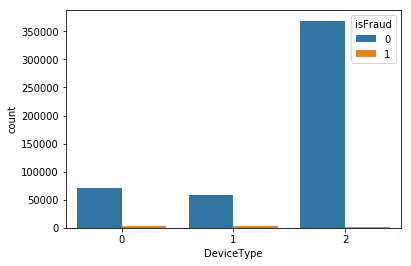

In [34]:
y_pred = log_clf.predict(X_test)
print(y_pred)
df_logical = df_test.copy()
#df_logical['isFraud'] = np.nan
df_logical['isFraud'] = y_pred
print(df_logical.head())

last = df_logical['isFraud']
print(last)

sns.countplot(df_logical['DeviceType'], hue='isFraud', data=df_logical)

#for i in y_pred:
#  df_logical.loc[y_pred] = [np.nan for _ in range(len(df_logical.columns)-1)]+[i]
#df_logical.head()
# And finally: show the results
#print(classification_report(y_test, y_pred))